In [123]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import scipy.ndimage as spi
import os
import pandas as pd
from astropy.wcs import WCS
from astropy.visualization import SqrtStretch, imshow_norm, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder
from astropy.nddata import Cutout2D
# from reproject import reproject_interp

pd.set_option('display.max_columns', 500)
np.set_printoptions(edgeitems=10)
np.core.arrayprint._line_width = 180
%matplotlib inline

In [124]:
datapath = "../data/RXJ1131-1231_j9ya08010_FILTER_F165LP_NA_EXPTIME2516.0_drz.fits"
data = fits.open(datapath)

In [125]:
data.info()

Filename: ../data/RXJ1131-1231_j9ya08010_FILTER_F165LP_NA_EXPTIME2516.0_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     695   ()      
  1  SCI           1 ImageHDU        63   (1392, 1366)   float32   
  2  WHT           1 ImageHDU        46   (1392, 1366)   float32   
  3  CTX           1 ImageHDU        39   (1392, 1366)   int32   
  4  HDRTAB        1 BinTableHDU    631   4R x 311C   [9A, 3A, K, D, D, D, D, D, D, D, D, D, D, D, D, D, K, 3A, 9A, 7A, 18A, D, D, D, D, D, 3A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 3A, D, D, D, D, K, K, K, D, K, 23A, 9A, 20A, D, D, D, D, D, D, D, D, 3A, D, D, D, D, K, K, 3A, 3A, D, D, D, D, D, D, 3A, D, D, D, D, D, D, D, D, 4A, 12A, 12A, 3A, 4A, 3A, 10A, 10A, D, D, 3A, 3A, 23A, 4A, 8A, 7A, 3A, D, K, D, 6A, 9A, D, D, D, L, 4A, 18A, 3A, K, 6A, 3A, D, D, D, 8A, D, 3A, L, K, L, K, L, K, K, 8A, 12A, D, D, D, D, 3A, 1A, D, 23A, D, D, D, 3A, 23A, L, D, 3A, D, 8A, 3A, 6A, D, L, L, D, D, D, D, D, D, D

In [126]:
data["SCI"].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1392                                                  
NAXIS2  =                 1366                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'SCI     '           / extension name                                 
EXTVER  =                    1                                                  
BUNIT   = 'ELECTRONS/S'        / Units of science product                       
                                                                                
CD1_1   = 1.89476327001595E-

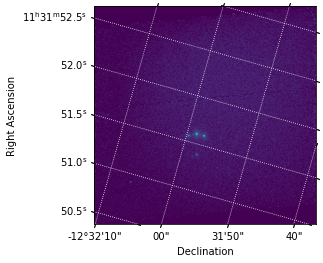

In [127]:
im = data["SCI"].data
im[np.isnan(im)] = 0
safe_log = lambda x: np.log(x + 1e-16)
wcs = WCS(data["SCI"].header)
plt.subplot(projection=wcs)
plt.imshow(im, norm=ImageNormalize(stretch=LogStretch()))
ax = plt.gca()


ax.coords[0].set_ticklabel_position('l')
ax.coords[0].grid(color='white', ls='dotted')
ax.set_ylabel('Right Ascension')
ax.coords[1].set_ticklabel_position('b')
ax.coords[1].grid(color='white', ls='dotted')
ax.set_xlabel('Declination');


# plt.plot(data["SCI"].header["CRPIX1"], data["SCI"].header["CRPIX2"], "ro")
# plt.colorbar()

In [128]:
# get position of images A, B, C and D

mean, median, std = sigma_clipped_stats(im,  sigma=3.0)
print(mean, median, std) # our points of interest

8.152801e-06 0.0 2.2723994e-05


In [129]:
print(200 * std)
print(np.nanmax(im))

0.004544798866845667
0.17308687


In [130]:
daofind = DAOStarFinder(fwhm=6.0, threshold=200.*std)
sources = daofind(im - median)

In [131]:
# help(DAOStarFinder)

In [132]:
for col in sources.colnames:
    sources[col].info.format = '%.8g'
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,643.315,435.19137,0.71535613,-0.0099632518,0.23999725,49,0,0.011926432,3.4577077,-1.3469707
2,689.54896,552.37375,0.55170432,-0.24827293,0.19399991,49,0,0.084966384,30.741863,-3.7193255
3,594.16295,553.79224,0.71628677,0.0062130871,0.22676076,49,0,0.043925907,13.47906,-2.824149
4,643.63852,564.16457,0.64106269,-0.07457213,0.24459418,49,0,0.17308687,56.853991,-4.3869024


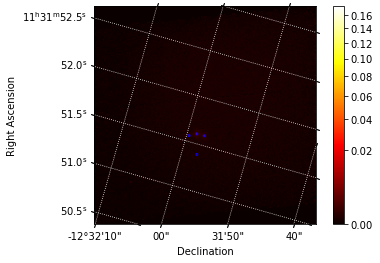

In [133]:
plt.subplot(projection=wcs)
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=6.)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(im, cmap="hot", norm=norm)
ax = plt.gca()
apertures.plot(color='blue', lw=1, alpha=1)
plt.colorbar()
ax.coords[0].set_ticklabel_position('l')
ax.coords[0].grid(color='white', ls='dotted')
ax.set_ylabel('Right Ascension')
ax.coords[1].set_ticklabel_position('b')
ax.coords[1].grid(color='white', ls='dotted')
ax.set_xlabel('Declination');

In [134]:
# help(SqrtStretch)
# help(CircularAperture)

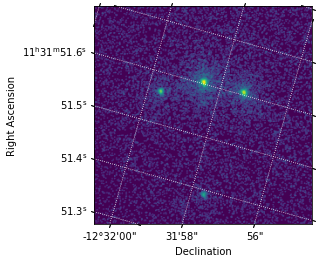

In [135]:

centroid = np.mean(positions, axis=0)
size = (250, 250)
cutout = Cutout2D(im, centroid, size, wcs=wcs)

plt.subplot(projection=cutout.wcs)
plt.imshow(cutout.data, norm=ImageNormalize(stretch=LogStretch()))
ax = plt.gca()
ax.coords[0].set_ticklabel_position('l')
ax.coords[0].grid(color='white', ls='dotted')
ax.set_ylabel('Right Ascension')
ax.coords[1].set_ticklabel_position('b')
ax.coords[1].grid(color='white', ls='dotted')
ax.set_xlabel('Declination');
# plt.plot(centroid[0], centroid[1], "ro")

In [205]:
sky = world.pixel_to_world(positions[:, 0], positions[:, 1])
sky

<SkyCoord (ICRS): (ra, dec) in deg
    [(172.96413009, -12.53267554), (172.96502183, -12.53258869),
     (172.96484639, -12.53322864), (172.96501342, -12.53291775)]>